In [9]:
cd ../momia2/

/Users/jzrolling/PycharmProjects/CleanSpace/momia2


In [2]:
import momia2 as mo

In [3]:
import glob
from matplotlib import pyplot as plt
from skimage.measure import approximate_polygon
from skimage.filters import gaussian

In [4]:
f = mo.momia_IO.ImageLoader(glob.glob('/Users/jzrolling/Desktop/Daisy_BODIPY/*.tif')[0])

In [5]:
%timeit m=f.get_slice_all_channels(position=0,time=0)

6.45 ms ± 55.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
data = f.get_slice_all_channels()

In [7]:
p = mo.Patch(image_dict=data.copy())
p.pixel_microns = 0.11
p.preprocess_images(mo.utils.dual_bandpass,
                    channels='ref',
                    pixel_microns = p.pixel_microns,
                    min_structure_scale=0.05,
                    max_structure_scale=25)
p.preprocess_images(mo.utils.rolling_ball_bg_subtraction,
                    channels=['C1'])
p.generate_mask(method=5)
p.label_mask()
p.locate_particles(use_intensity=False)
p.find_outline(approximate=True)
p.filter_particles(filter_dict={'area': (10, 1000),
                              'aspect_ratio': (0.05, 0.6),
                              'solidity': (0.4, 1),
                              'eccentricity': (0.4, 1),
                              'min_negative_curvature': (-10,100)})

Rendering cell plot(s)...


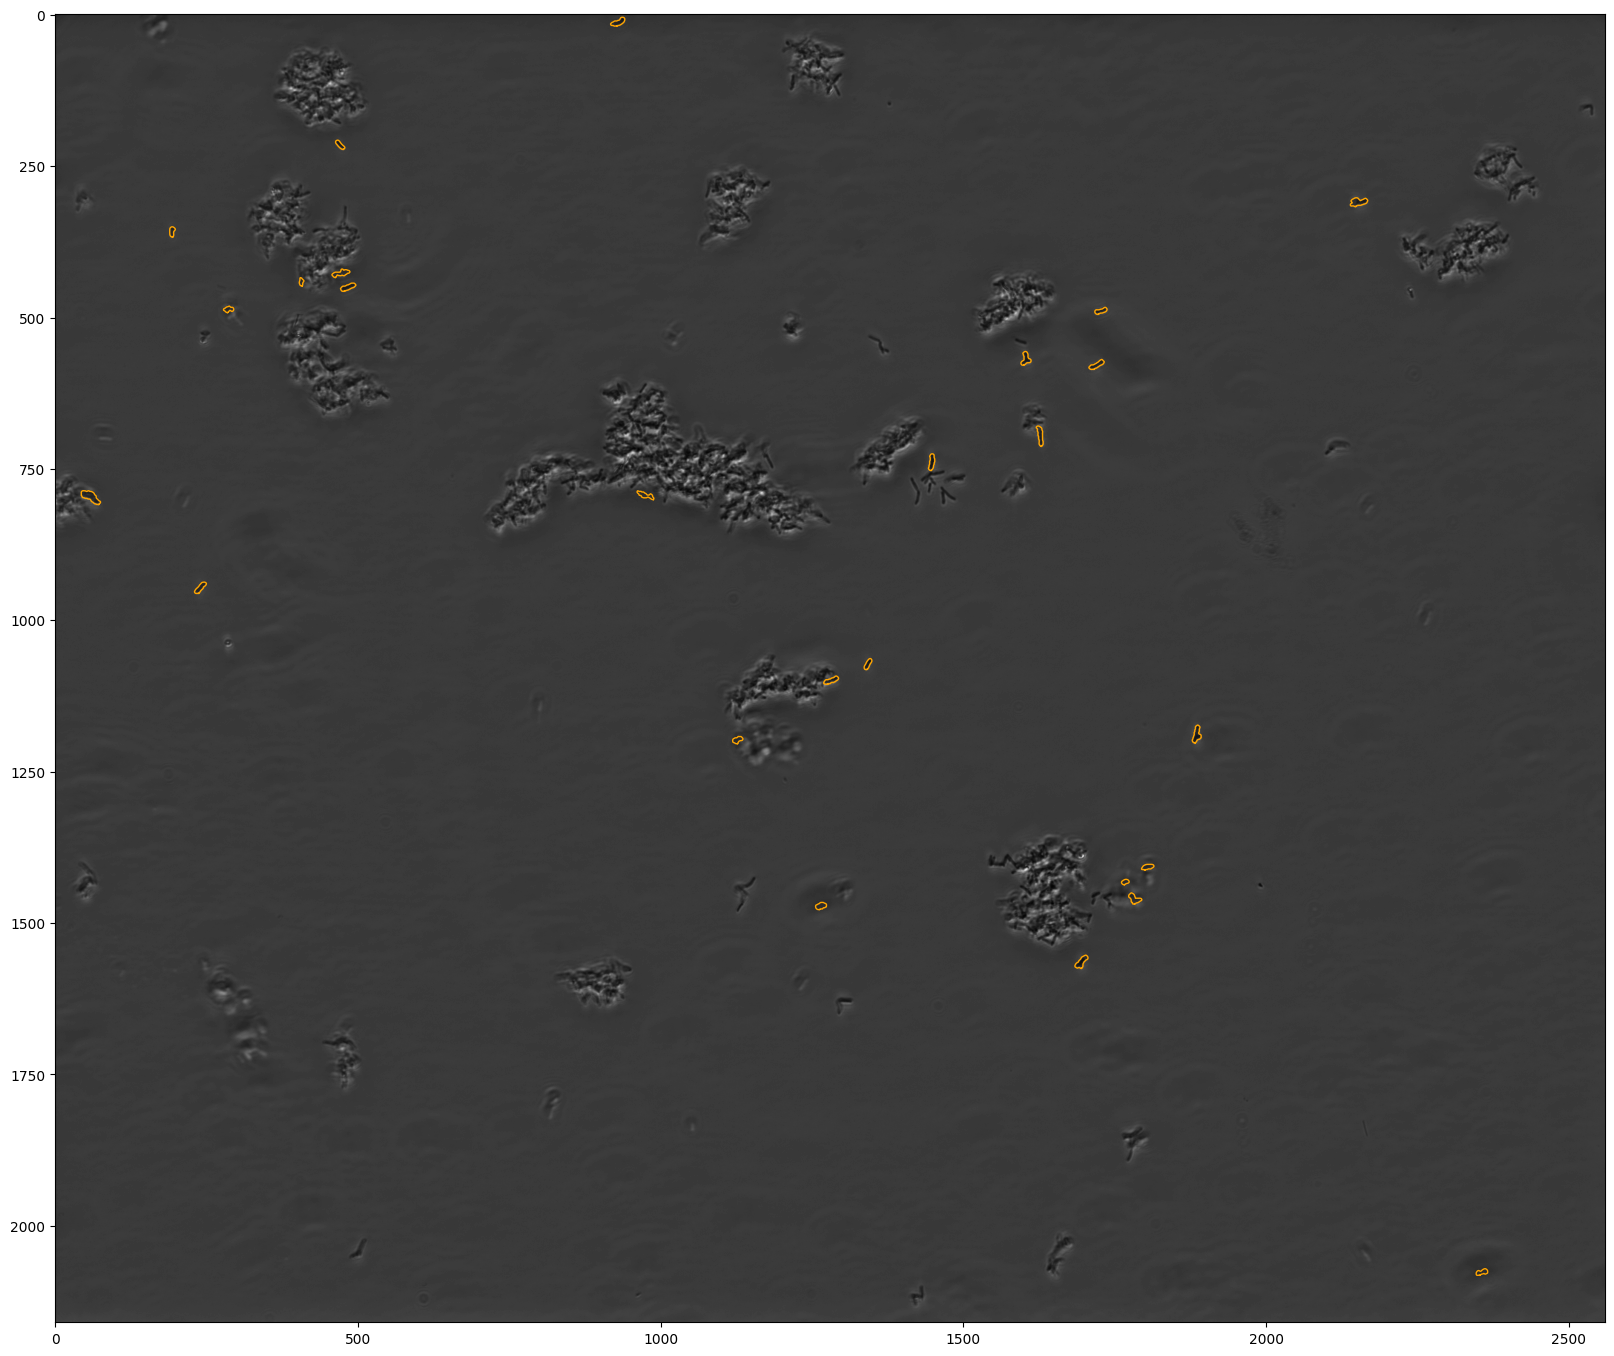

In [8]:
p.plot(figsize=(20,20))

In [11]:
filtered = p.regionprops[p.regionprops['$include']==1]

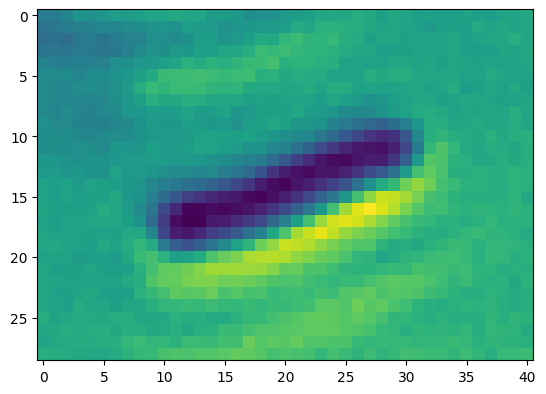

In [20]:
plt.imshow(p.get_particle_data(filtered.index[6])['C2'])

In [21]:
cell = filtered.index[6]

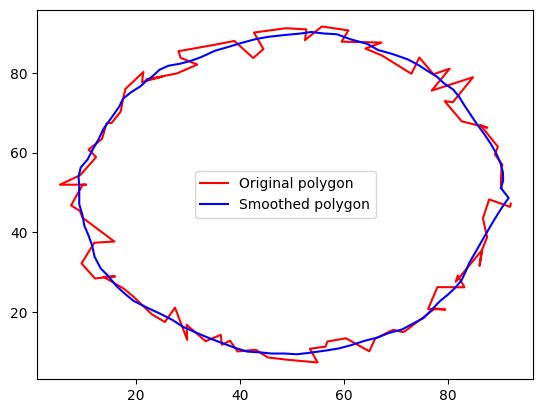

In [313]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def smooth_polygon(polygon, window_length, polyorder,closed=True):
    # The Savitzky-Golay filter requires the window length to be odd
    if window_length % 2 == 0:
        window_length += 1

    # Apply the filter to smooth the polygon
    polygon_smooth = np.empty_like(polygon)
    polygon_smooth[:, 0] = savgol_filter(polygon[:, 0], window_length, polyorder)
    polygon_smooth[:, 1] = savgol_filter(polygon[:, 1], window_length, polyorder)
    if closed:
        if (polygon_smooth[-1]-polygon_smooth[0]).mean()!=0:
            polygon_smooth = np.vstack([polygon_smooth,[polygon_smooth[0]]])
    
    return polygon_smooth

# Example usage:
# Create a noisy polygon
polygon = np.array([50 + 40 * np.cos(t) + np.random.normal(0, 2) for t in np.linspace(0, 2 * np.pi, 100)])
polygon = np.column_stack([polygon, [50 + 40 * np.sin(t) + np.random.normal(0, 2) for t in np.linspace(0, 2 * np.pi, 100)]])

# Smooth the polygon
smoothed_polygon = smooth_polygon(polygon, window_length=15, polyorder=3)

# Plot the original and smoothed polygons
fig, ax = plt.subplots()
ax.plot(polygon[:, 0], polygon[:, 1], 'r', label='Original polygon')
ax.plot(smoothed_polygon[:, 0], smoothed_polygon[:, 1], 'b', label='Smoothed polygon')
ax.legend()
plt.show()

(0.0, 512.0, 512.0, 0.0)

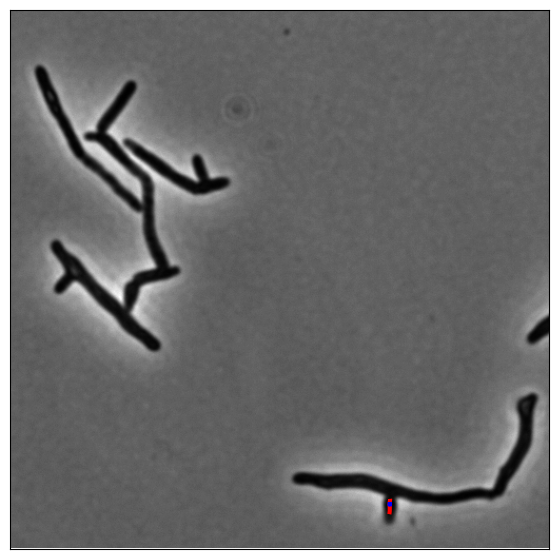

In [476]:
import numpy as np
from skimage.measure import approximate_polygon
from skimage.draw import polygon_perimeter
from skimage.segmentation import active_contour
import matplotlib.pyplot as plt

def active_contour_centerline(polyline, polygon, 
                              alpha=0.1, beta=1.0, w_line=0, 
                              w_edge=1, gamma=0.1, max_px_move=1.0, 
                              max_iterations=2500):
    # Create an empty image
    img = np.zeros((500, 500))

    # Draw the polygon to the image
    rr, cc = polygon_perimeter(polygon[:,0], polygon[:,1], shape=img.shape, clip=False)
    img[rr, cc] = 1

    # Use active contour to evolve the polyline
    snake = active_contour(img,
                           polyline,
                           alpha=alpha,  # Smoothness parameter
                           beta=beta,  # Linearity parameter
                           w_line=w_line,  # Attraction to brightness
                           w_edge=w_edge,  # Attraction to edges
                           gamma=gamma,  # Explicit time stepping parameter
                           max_px_move=max_px_move,
                           max_num_iter=max_iterations)

    return snake

# Define your polyline and polygon here
polyline = xx
polygon = contour

# Evolve the polyline
centerline = active_contour_centerline(polyline, polygon)

# Plot the result
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(polyline[:, 1], polyline[:, 0], '--r', lw=3)
ax.plot(centerline[:, 1], centerline[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

In [308]:
def smooth_binary_mask(mask, sigma=1.5):
    smooth_mask = gaussian(mask*1, sigma=sigma,preserve_range=True)
    return smooth_mask > 0.5

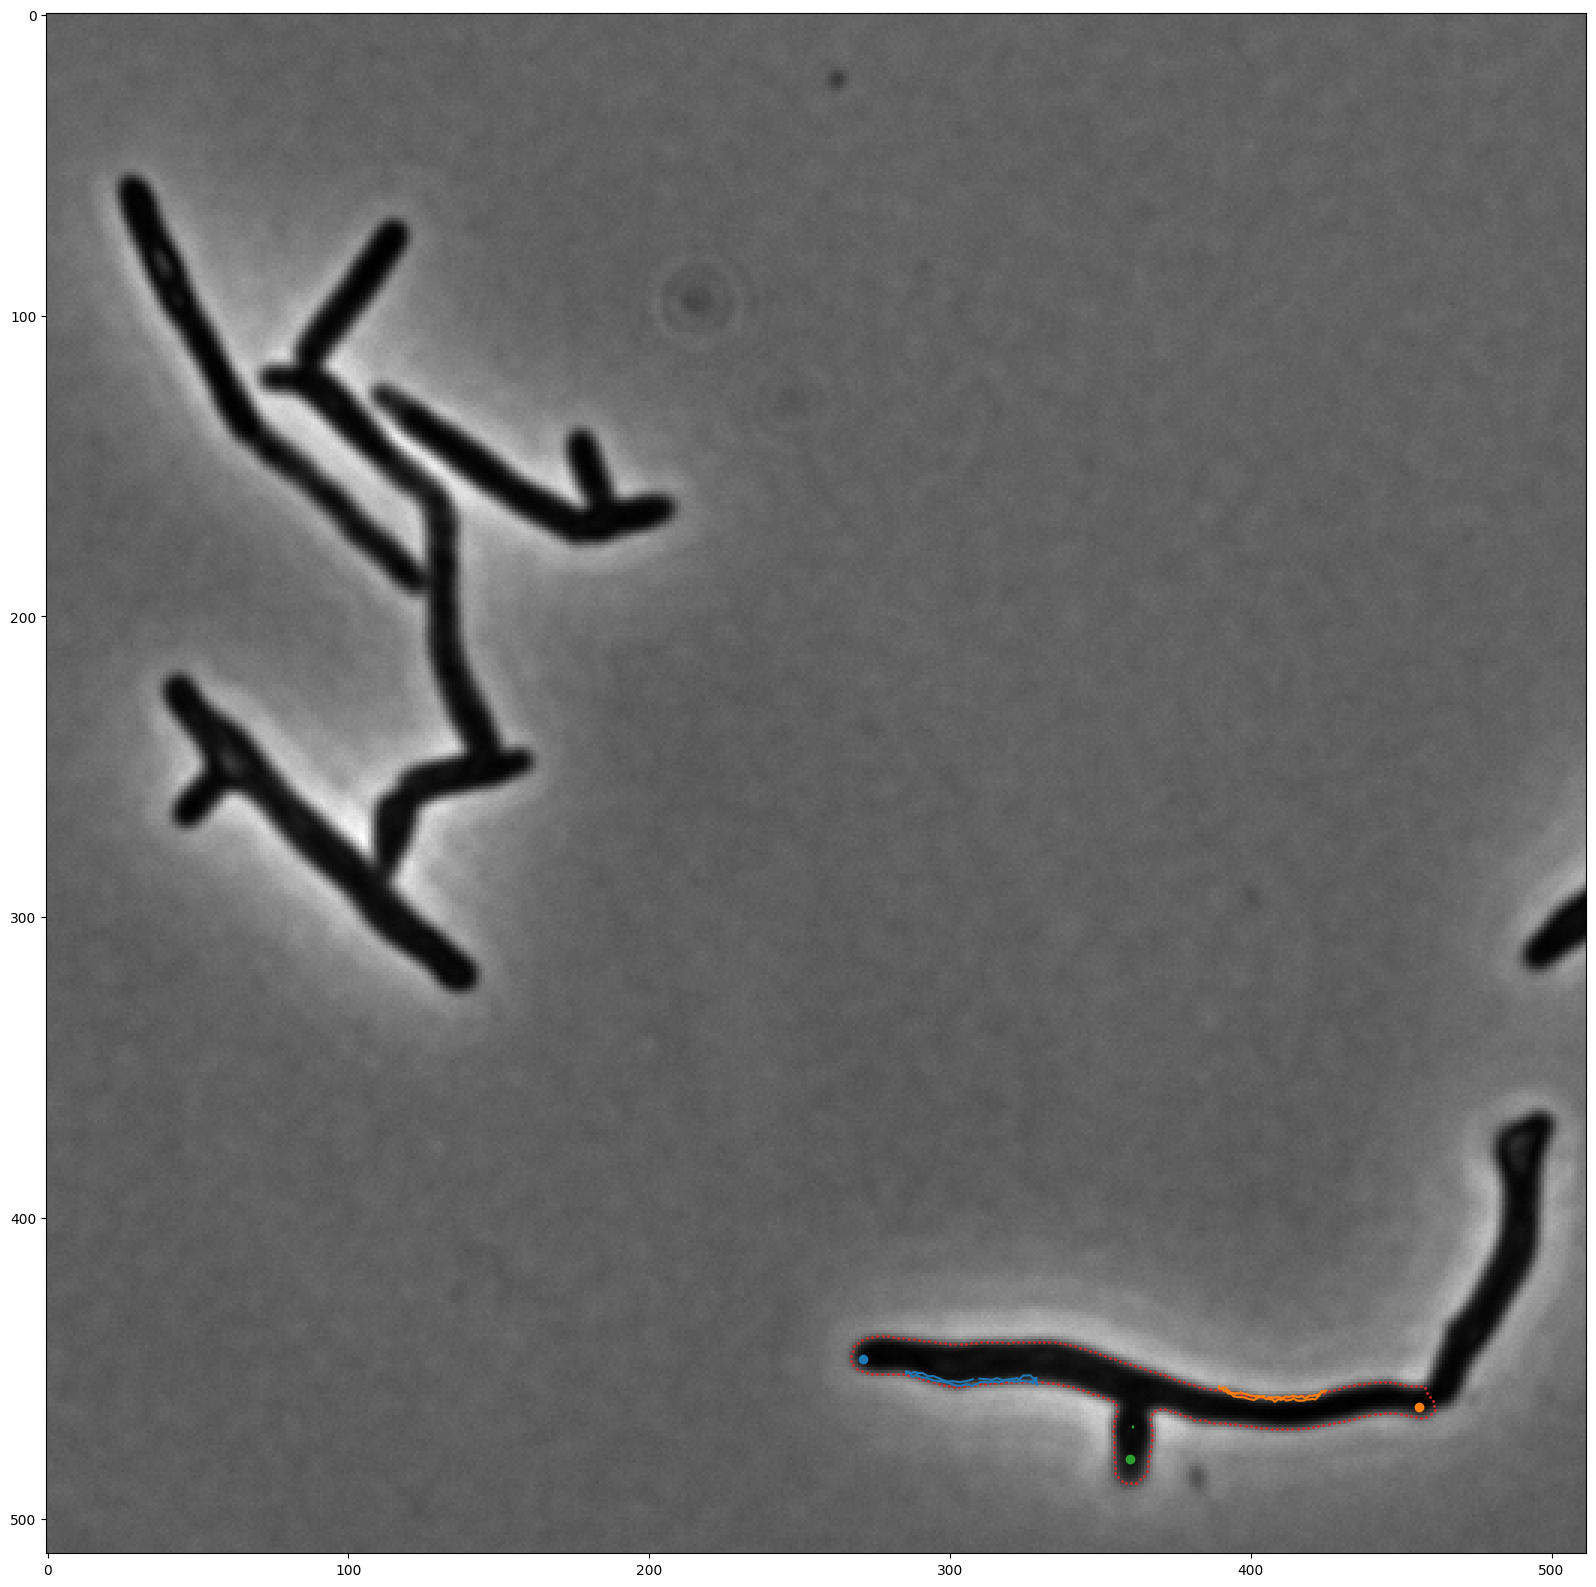

In [478]:
fig=plt.figure(figsize=(20,20))
cell = smooth_binary_mask(((mask==9)*1))
img_clip = img
contour,int_mask = find_contour_marching_squares(cell,img_clip,level=0.5,dilation=True,erosion=False,dark_background=False)
contour = spline_approximation(contour,n=int(len(contour)*0.5),closed=False,smooth_factor=1)
sk = skeleton_analysis(cell,pruning=True)
plt.imshow(img_clip,cmap='gist_gray')
for x in sk[0]:
    """
    xx=extend_skeleton(np.array(x[1:]).T,
                       contour,
                       find_pole1=x[0][0],
                       find_pole2=x[0][1],
                       interpolation_factor=2)
    
    xx=midline_approximation(np.array(x[1:]).T[1:-1],
                             contour,
                             move_pole1=x[0][0],
                             move_pole2=x[0][1],
                             anchor_length=5,
                             max_iteration=30,tolerance=0.1)[0]
    """
    xx = active_contour_centerline(np.array(x[1:]).T[1:-1], contour)

    plt.scatter(x[2][0],x[1][0])
    plt.plot(xx[:,1],xx[:,0])
    
plt.scatter(contour[:,1],contour[:,0],s=1)
#plt.xlim(100,250)
#plt.ylim(200,200)

In [ ]:
from numba import jit
import warnings

def distance(v1, v2):
    # Euclidean distance of two points
    return np.sqrt(np.sum((np.array(v1) - np.array(v2)) ** 2))

def skeleton_analysis(mask,
                      pruning=False,
                      min_branch_length=5,
                      max_iterations=30):
    """

    :param mask:
    :param pruning:
    :param min_branch_length:
    :param max_iterations:
    :return:
    """
    
    from skimage import morphology, measure
    
    warnings.filterwarnings("ignore")
    skeleton = morphology.skeletonize(mask)*2
    endpoints, branch_points, skeleton = locate_nodes(skeleton)
    anchor_points = endpoints+branch_points
    skeleton_branches = []
    n = 0
    if (len(endpoints) >= 2) and (len(branch_points) <= 10):
        while True:
            if len(anchor_points) == 0:
                break
            if n>=max_iterations:
                break
            is_real_pole = [0,0]
            startpoint = anchor_points[0]
            if startpoint in endpoints:
                is_real_pole[0] = 1
            xcoords,ycoords = neighbor_search(skeleton,startpoint)
            anchor_points.remove(startpoint)
            if len(xcoords)>=1:
                lx,ly = xcoords[-1],ycoords[-1]
                node_count, node_coords = cubecount_with_return(skeleton, lx, ly, 3)
                if (node_count == 0) and ([lx,ly] in endpoints):
                    is_real_pole[1] = 1
                    anchor_points.remove([lx, ly])
                elif (node_count == 1):
                    lx, ly = node_coords[0]
                    if [lx, ly] in anchor_points:
                        anchor_points.remove([lx, ly])
                    xcoords.append(lx)
                    ycoords.append(ly)
                else:
                    for xy in node_coords:
                        if distance([lx,ly],xy) == 1:
                            lx,ly = xy
                            break
                    if [lx, ly] in anchor_points:
                        anchor_points.remove([lx, ly])
                    xcoords.append(lx)
                    ycoords.append(ly)
                skeleton_branches.append([is_real_pole, xcoords, ycoords])
            n+=1
        branch_copy = skeleton_branches.copy()
        if pruning:
            for branch in branch_copy:
                if len(branch[1]) <= min_branch_length:
                    skeleton_branches.remove(branch)
            if len(skeleton_branches)==1:
                skeleton_branches[0][0]=[1,1]
        if n < max_iterations:
            return skeleton_branches, skeleton
        else:
            return [], skeleton
    else:
        return [], skeleton
    
    
def locate_nodes(skeleton):
    warnings.filterwarnings("ignore")
    """

    :param skeleton: binary skeleton generated by calling skimage.morphology.skeletonize
    :return: a list of three short lists of coordinates:
             @endpoints: outreaching pole coordinates, there should be one for each branch
             @branch_points: branching point coordinates, there should be one for each branch
             @skeleton: labeled skeleton
    """
    endpoints = []
    branch_points = []
    skeleton_path = np.where(skeleton > 0)
    skeleton_length = len(skeleton_path[0])
    if skeleton_length > 5:
        for i in range(skeleton_length):
            x = skeleton_path[0][i]
            y = skeleton_path[1][i]
            if cube_nonzero(skeleton, x, y) == 1:
                endpoints.append([x, y])
            if cube_nonzero(skeleton, x, y) == 2:
                _n, _neighbors = cube_nonzero_with_return(skeleton, x, y)
                _x0, _y0 = _neighbors[0]
                _x1, _y1 = _neighbors[1]
                dist = abs(_x0 - _x1) + abs(_y0 - _y1)
                if dist == 1:
                    skeleton[x, y] = 0
                    if skeleton[_x0, _y0] == 3:
                        skeleton[_x0, _y0] = 2
                    if skeleton[_x1, _y1] == 3:
                        skeleton[_x1, _y1] = 2
                    if [_x0, _y0] in branch_points:
                        branch_points.remove([_x0, _y0])
                    if [_x1, _y1] in branch_points:
                        branch_points.remove([_x1, _y1])
            if cube_nonzero(skeleton, x, y) > 2:
                branch_points.append([x, y])
                skeleton[x, y] = 3
        return endpoints, branch_points, skeleton
    else:
        return endpoints, branch_points, skeleton


@jit(nopython=True, cache=True)
def neighbor_search(input_map, endpoint, max_iterations=500):
    output_x = []
    output_y = []
    end_reached = False
    x, y = endpoint[0], endpoint[1]
    counter = 0
    while not end_reached:
        if counter >= max_iterations:
            break
        n_neighbor, neighbor_list = cubecount_with_return(input_map, x, y, 2)
        if n_neighbor == 0:
            input_map[x, y] = 1
            output_x.append(x)
            output_y.append(y)
            end_reached = True
        elif n_neighbor == 1:
            input_map[x, y] = 1
            output_x.append(x)
            output_y.append(y)
            x, y = neighbor_list[-1]
        elif n_neighbor >= 2:
            input_map[x, y] = 1
            output_x.append(x)
            output_y.append(y)
            end_reached = True
        counter += 1
    return output_x, output_y


@jit(nopython=True, cache=True)
def cubesum(mask, px, py, val):
    n = 0
    for i in [0, 1, 2, 3, 5, 6, 7, 8]:
        dx = int(i / 3)
        dy = i - dx * 3
        x1, y1 = px + dx - 1, py + dy - 1
        if mask[x1, y1] == val:
            n += 1
    return n


@jit(nopython=True, cache=True)
def cube_nonzero(mask, px, py):
    n = 0
    for i in [0, 1, 2, 3, 5, 6, 7, 8]:
        dx = int(i / 3)
        dy = i - dx * 3
        x1, y1 = px + dx - 1, py + dy - 1
        if mask[x1, y1] > 0:
            n += 1
    return n


@jit(nopython=True, cache=True)
def cube_nonzero_with_return(mask, px, py):
    retlist = []
    n = 0
    for i in [0, 1, 2, 3, 5, 6, 7, 8]:
        dx = int(i / 3)
        dy = i - dx * 3
        x1, y1 = px + dx - 1, py + dy - 1
        if mask[x1, y1] > 0:
            retlist.append([x1, y1])
            n += 1
    return n, retlist


@jit(nopython=True, cache=True)
def cubecount_with_return(mask, px, py, val):
    retlist = []
    n = 0
    for i in [0, 1, 2, 3, 5, 6, 7, 8]:
        dx = int(i / 3)
        dy = i - dx * 3
        x1, y1 = px + dx - 1, py + dy - 1
        if mask[x1, y1] == val:
            retlist.append([x1, y1])
            n += 1
    return n, retlist

def extend_skeleton(smoothed_skeleton, smoothed_contour,
                    find_pole1=True, find_pole2=True, subdivide_pole_segment=5,
                    interpolation_factor=1):
    # initiate approximated tip points
    new_pole1, new_pole2, smoothed_skeleton = find_poles(smoothed_skeleton,
                                                         smoothed_contour,
                                                         find_pole1=find_pole1,
                                                         find_pole2=find_pole2)
    
    extended_skeleton = []
    if find_pole1:
        segment1 = (np.array([np.linspace(new_pole1[0][0],smoothed_skeleton[0,0],subdivide_pole_segment),
                             np.linspace(new_pole1[0][1],smoothed_skeleton[0,1],subdivide_pole_segment)]).T)[:-1]
    else:
        segment1 = new_pole1
    if find_pole2:
        segment2 = (np.array([np.linspace(smoothed_skeleton[-1,0],new_pole2[0][0],subdivide_pole_segment),
                              np.linspace(smoothed_skeleton[-1,1],new_pole2[0][1],subdivide_pole_segment)]).T)[1:]
    else:
        segment2 = new_pole2
        
    
    extended_skeleton = np.concatenate([segment1,
                                        smoothed_skeleton,
                                        segment2])
    return spline_approximation(extended_skeleton,
                                n=int(interpolation_factor * len(smoothed_skeleton)),
                                smooth_factor=1, closed=False)
    #return extended_skeleton

def find_poles(smoothed_skeleton,
               smoothed_contour,
               find_pole1=True,
               find_pole2=True,
               gap=4):
    """

    :param smoothed_skeleton:
    :param smoothed_contour:
    :param find_pole1:
    :param find_pole2:
    :param gap:
    :return:
    """
    # find endpoints and their nearest neighbors on a midline
    length = len(smoothed_skeleton)
    extended_pole1 = [smoothed_skeleton[0]]
    extended_pole2 = [smoothed_skeleton[-1]]
    i = 0
    j = 0
    if find_pole1:
        for i in range(0,5):
            p1 = smoothed_skeleton[i]
            p2 = smoothed_skeleton[i + gap]
            # find the two intersection points between
            # the vectorized contour and line through pole1
            intersection_points_pole1 = line_contour_intersection(p1, p2, smoothed_contour)
            # find the interesection point with the same direction as the outward pole vector
            dxy_1 = p1 - p2
            p1_tile = np.tile(p1, (len(intersection_points_pole1), 1))
            p1dot = (intersection_points_pole1 - p1_tile) * dxy_1
            index_1 = np.where((p1dot[:, 0] > 0) & (p1dot[:, 1] > 0))[0]
            if len(index_1) > 0:
                extended_pole1 = intersection_points_pole1[index_1]
                break
    else:
        i = 1

    if find_pole2:
        for j in range(0,5):
            p3 = smoothed_skeleton[-1 - j]
            p4 = smoothed_skeleton[-1-gap - j]
            # find the two intersection points between
            # the vectorized contour and line through pole1
            intersection_points_pole2 = line_contour_intersection(p3, p4, smoothed_contour)
            # find the interesection point with the same direction as the outward pole vector
            dxy_2 = p3 - p4
            p3_tile = np.tile(p3, (len(intersection_points_pole2), 1))
            p3dot = (intersection_points_pole2 - p3_tile) * dxy_2
            index_2 = np.where((p3dot[:, 0] > 0) & (p3dot[:, 1] > 0))[0]
            if len(index_2) > 0:
                extended_pole2 = intersection_points_pole2[index_2]
                break
    else:
        j = 1
    trimmed_midline = smoothed_skeleton[i:length - j]
    return extended_pole1, extended_pole2, trimmed_midline




def line_contour_intersection(p1, p2, contour):
    v1, v2 = contour[:-1], contour[1:]
    x1, y1 = v1.T
    x2, y2 = v2.T
    x3, y3 = p1
    x4, y4 = p2
    xy = np.array(intersect_lines(x1, y1, x2, y2, x3, y3, x4, y4)).T
    dxy_v1 = xy - v1
    dxy_v2 = xy - v2
    dxy = dxy_v1 * dxy_v2
    intersection_points = xy[np.where(np.logical_and(dxy[:, 0] < 0, dxy[:, 1] < 0))]
    if len(intersection_points) > 2:
        dist = np.sum(np.square(np.tile(p1, (len(intersection_points), 1)) - intersection_points),
                      axis=1)
        intersection_points = intersection_points[np.argsort(dist)[0:2]]
    return intersection_points


def midline_approximation(skeleton, 
                          smoothed_contour,
                          move_pole1 = False,
                          move_pole2 = False, 
                          anchor_length = 3,
                          tolerance=0.1, max_iteration=10):
    """
    Approximation of a smooth midline with skeleton and a smoothed contour.

    :param skeleton: A numpy array of shape (n, 2) representing the skeleton of a 2D object.
    :param smoothed_contour: A numpy array of shape (m, 2) representing the smoothed contour of a 2D object.
    :param tolerance: A float representing the maximum distance between the midline and the skeleton at which convergence is achieved.
    :param max_iteration: An integer representing the maximum number of iterations to perform.
    :return: A tuple containing a numpy array of shape (p, 2) representing the midline approximation and a boolean indicating whether convergence was achieved.
    """
    midline = skeleton.copy()
    pole1_anchor = []
    pole2_anchor = []
    
    if not move_pole1:
        pole1_anchor = midline[:anchor_length]
        midline = midline[anchor_length:]
    if not move_pole2:
        pole2_anchor = midline[-anchor_length:]
        midline = midline[:-anchor_length]
    
    n = 0
    converged = False
    while n < max_iteration:
        updated_midline = skeleton_contour_intersect_points(midline, smoothed_contour)
        dxy = updated_midline - midline
        midline = spline_approximation(updated_midline, 
                                       n=len(updated_midline),
                                       smooth_factor=1, closed=False)
        midline = smooth_polygon(midline,3,2,closed=False)
        if dxy.max() <= tolerance:
            converged = True
            break
        n += 1
        
    stiched_midline = []
    if not move_pole1:
        stiched_midline.append(pole1_anchor)
    stiched_midline.append(midline)
    if not move_pole2:
        stiched_midline.append(pole2_anchor)
    print(pole1_anchor,pole2_anchor)
    midline = np.vstack(stiched_midline)
    return midline.astype(np.float), converged